# Feature engineering
The purpose of this nootebook is to discover which feature is important for our model.

### Libraries

In [3]:
# external
import datetime as dt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# internal
from dataLoader.DataLoader import DataLoader
from models.RfModel import RFModel
from evaluations.Evaluations import metrics

# Plotting
import matplotlib.pyplot as plt
from utils.plots import Plots

### 1 - Slinding window approach?

We will use the first 20 years of data for training predictive models and the final year for evaluating models.

The data will be divided into weeks, 14 values  (since for each day we've computed 2 values of the tidal coefficient). And the next 14 values would constitute the prediction target for the models.

In [7]:
DL = DataLoader()
DL.createDataFrame()

data successfully loaded 


C:\Users\Otmane\anaconda3\envs\prediciton_of_tidal_coefficient\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [8]:
RF = RFModel(params = {"n_estimators":100})

In [9]:
X_train_reshaped, X_test_reshaped, y_train, y_test = DL.splitDataSet(past_values=14, step=14)

In [10]:
RF.fit(X_train_reshaped, y_train)

In [11]:
y_predicted = RF.predict(X_test_reshaped)
score, scores = RF.evaluate(X_test_reshaped, y_test)

the RMSE for all predictions is:6.4315838145790405
----------------------------------------------------------------------------------------------------


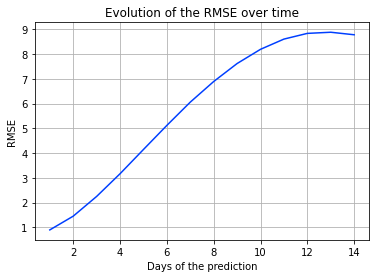

In [12]:
print("the RMSE for all predictions is:{}".format(score))

print("-"*100)

plt.plot(np.arange(14)+1, scores)
plt.xlabel("Days of the prediction")
plt.ylabel("RMSE")
plt.grid()
plt.title("Evolution of the RMSE over time");

- The errors above indicate that our model performs well for the first value of the first day prediction and it does worse as we want to predict further steps in time. But Since the RMSE computed here has the same unit "roughly speaking: our actual value has no unit".

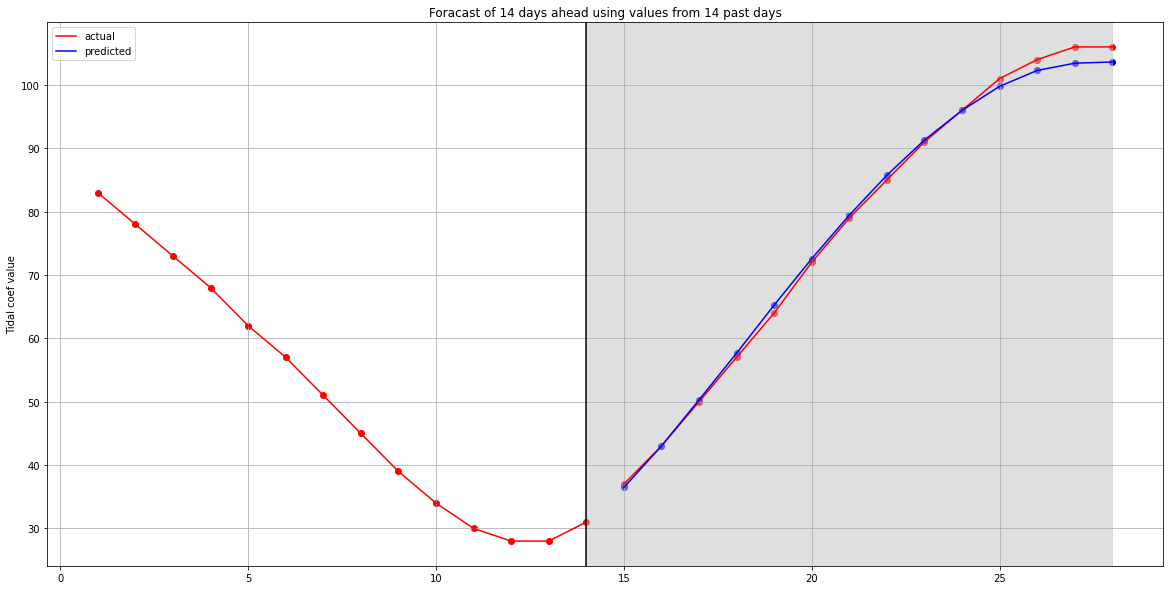

In [13]:
pl = Plots((20,10))
pl.plotForcast(X_test_reshaped, y_test, y_predicted, 88)

### 2 - Time Features only?

In [14]:
DL = DataLoader()
DL.createDataFrame()
DL.addTimRelatedFeatures()

C:\Users\Otmane\anaconda3\envs\prediciton_of_tidal_coefficient\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


data successfully loaded 
Date-Time features added with sucess!


In [15]:
DL.data.head()

,dateTime,coef,hijri_day,hijri_month,hijri_year,hour
0,2000-01-01 12:21:00,48,24,9,1420,12
1,2000-01-02 00:53:00,50,25,9,1420,0
2,2000-01-02 13:19:00,53,25,9,1420,13
3,2000-01-03 01:45:00,56,26,9,1420,1
4,2000-01-03 14:08:00,60,26,9,1420,14


In [16]:
df = DL.data

In [17]:
df['year'] = df["dateTime"].dt.year.values
df_test = df[df["year"]==2021]
df_train = df[df["year"]!=2021]

In [18]:
df_train.head()

,dateTime,coef,hijri_day,hijri_month,hijri_year,hour,year
0,2000-01-01 12:21:00,48,24,9,1420,12,2000
1,2000-01-02 00:53:00,50,25,9,1420,0,2000
2,2000-01-02 13:19:00,53,25,9,1420,13,2000
3,2000-01-03 01:45:00,56,26,9,1420,1,2000
4,2000-01-03 14:08:00,60,26,9,1420,14,2000


In [19]:
X_train = df_train.iloc[:,2:-1]
y_train = df_train.iloc[:,1]

X_test = df_test.iloc[:,2:-1]
y_test = df_test.iloc[:,1]

In [20]:
RF = RFModel(params = {"n_estimators":100})

In [21]:
RF.fit(X_train, y_train)

In [22]:
y_predicted = RF.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)

In [23]:
print("overal root mean squared error is: {}".format(rmse))

overal root mean squared error is: 9.955707087747273


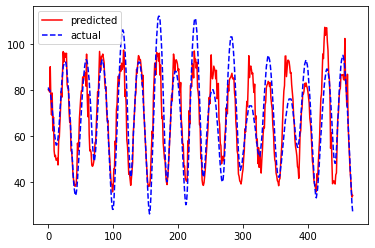

In [24]:
plt.plot(np.arange(y_predicted.shape[0]), y_predicted, '-r', label = "predicted")
plt.plot(np.arange(y_test.shape[0]), y_test, '--b', label = 'actual')
plt.legend();

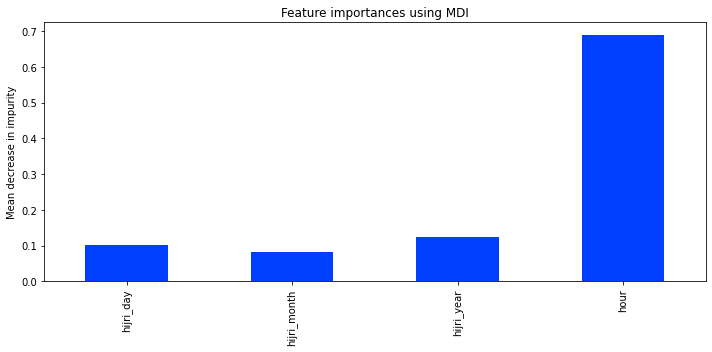

In [25]:
rf_model = RF.model

importances = rf_model.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize = (10, 5))
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### 3- Moon & sun related features only?

In [26]:
DL = DataLoader()
DL.createDataFrame()
DL.addMoonSunFeatures()

C:\Users\Otmane\anaconda3\envs\prediciton_of_tidal_coefficient\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


data successfully loaded 
Features added successfully!


In [27]:
df = DL.data
df.head()

,dateTime,coef,moon_phase,earth_moon_distance,sun_moon_distance,libration_lat,libration_long,subsolar_latitude,elongation,earth_sun_distance
0,2000-01-01 12:21:00,48,0.272007,0.002680,0.982105,-0.118238,0.096808,0.011175,-1.094243,0.983332
1,2000-01-02 00:53:00,50,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325
2,2000-01-02 13:19:00,53,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325
3,2000-01-03 01:45:00,56,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322
4,2000-01-03 14:08:00,60,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322


In [28]:
df['year'] = df["dateTime"].dt.year.values
df_test = df[df["year"]==2021]
df_train = df[df["year"]!=2021]

In [29]:
X_train = df_train.iloc[:,2:-1]
y_train = df_train.iloc[:,1]

X_test = df_test.iloc[:,2:-1]
y_test = df_test.iloc[:,1]

In [30]:
RF = RFModel(params = {"n_estimators":100})
RF.fit(X_train, y_train)
y_predicted = RF.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)

In [31]:
print("overal root mean squared error is: {}".format(rmse))

overal root mean squared error is: 4.928144100521423


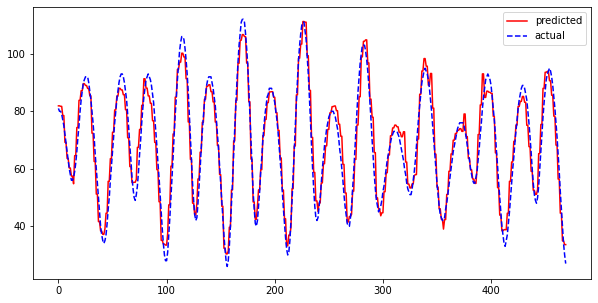

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(y_predicted.shape[0]), y_predicted, '-r', label = "predicted")
plt.plot(np.arange(y_test.shape[0]), y_test, '--b', label = 'actual')
plt.legend();

- Features importances based on mean decrease in impurity

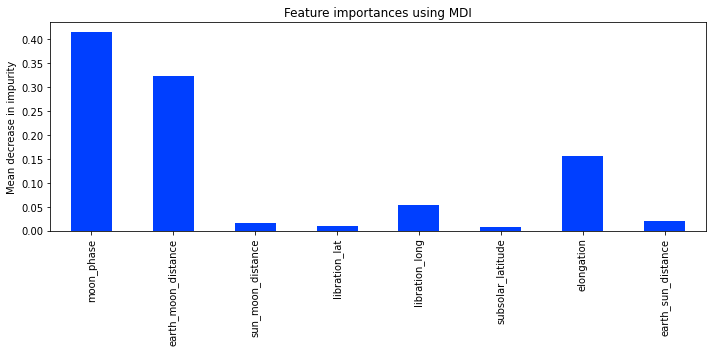

In [33]:
rf_model = RF.model

importances = rf_model.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize = (10, 5))
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### 4 - Both 2 and 3?

In [34]:
DL = DataLoader()
DL.createDataFrame()
DL.addMoonSunFeatures()
DL.addTimRelatedFeatures()

C:\Users\Otmane\anaconda3\envs\prediciton_of_tidal_coefficient\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


data successfully loaded 
Features added successfully!
Date-Time features added with sucess!


In [39]:
df = DL.data
df.head()

,dateTime,coef,moon_phase,earth_moon_distance,sun_moon_distance,libration_lat,libration_long,subsolar_latitude,elongation,earth_sun_distance,hijri_day,hijri_month,hijri_year,hour
0,2000-01-01 12:21:00,48,0.272007,0.002680,0.982105,-0.118238,0.096808,0.011175,-1.094243,0.983332,24,9,1420,12
1,2000-01-02 00:53:00,50,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325,25,9,1420,0
2,2000-01-02 13:19:00,53,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325,25,9,1420,13
3,2000-01-03 01:45:00,56,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322,26,9,1420,1
4,2000-01-03 14:08:00,60,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322,26,9,1420,14


In [40]:
df['year'] = df["dateTime"].dt.year.values
df_test = df[df["year"]==2021]
df_train = df[df["year"]!=2021]

In [41]:
df_train.head()

,dateTime,coef,moon_phase,earth_moon_distance,sun_moon_distance,libration_lat,libration_long,subsolar_latitude,elongation,earth_sun_distance,hijri_day,hijri_month,hijri_year,hour,year
0,2000-01-01 12:21:00,48,0.272007,0.002680,0.982105,-0.118238,0.096808,0.011175,-1.094243,0.983332,24,9,1420,12,2000
1,2000-01-02 00:53:00,50,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325,25,9,1420,0,2000
2,2000-01-02 13:19:00,53,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325,25,9,1420,13,2000
3,2000-01-03 01:45:00,56,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322,26,9,1420,1,2000
4,2000-01-03 14:08:00,60,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322,26,9,1420,14,2000


In [42]:
X_train = df_train.iloc[:,2:-1]
y_train = df_train.iloc[:,1]

X_test = df_test.iloc[:,2:-1]
y_test = df_test.iloc[:,1]

In [43]:
RF = RFModel(params = {"n_estimators":100})
RF.fit(X_train, y_train)
y_predicted = RF.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)

In [44]:
print("overal root mean squared error is: {}".format(rmse))

overal root mean squared error is: 5.039136113061191


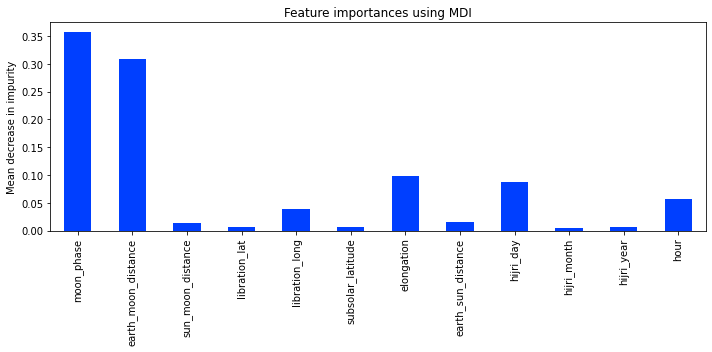

In [45]:
rf_model = RF.model

importances = rf_model.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize = (10, 5))
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

- some features seems to be more important than others in terms of mean decrease in impurity :
    - moon_phase.
    - earth_moon_distance
    - elongation:
    - hijri_day:
    - hour:
    - liberation longitude:

### 5 - Feature Selection:


#### - Recursive Feature Elimination (RFE)

In [118]:
DL = DataLoader()
DL.createDataFrame()
DL.addMoonSunFeatures()
DL.addTimRelatedFeatures()
df = DL.data

C:\Users\Otmane\anaconda3\envs\prediciton_of_tidal_coefficient\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


data successfully loaded 
Features added successfully!
Date-Time features added with sucess!


In [119]:
df['year'] = df["dateTime"].dt.year.values
df_test = df[df["year"]==2021]
df_train = df[df["year"]!=2021]

In [120]:
X_train = df_train.iloc[:,2:]
y_train = df_train.iloc[:,1]

X_test = df_test.iloc[:,2:]
y_test = df_test.iloc[:,1]

In [121]:
RF = RFModel(params = {"n_estimators":100})
RF.fit(X_train,y_train)
rmse_test=[]
rmse_train = []
droped_features=[]
for i in range (X_train.shape[1]-1):
    # making prediction 
    y_predicted = RF.predict(X_test)
    y_predicted_train = RF.predict(X_train)

    # computing error
    rmse_test.append(mean_squared_error(y_test, y_predicted, squared=False))
    rmse_train.append(mean_squared_error(y_train, y_predicted_train, squared=False))

    # getting feature importances
    features_imp=np.array(RF.model.feature_importances_)

    # getting the less impotant feature based on mean decrease in impurity
    f_less_imp=np.argmin(features_imp)
    droped_features.append(X_train.columns[f_less_imp])

    # dropping the lest important feature
    X_train=X_train.drop([X_train.columns[f_less_imp]],axis=1)
    X_test=X_test.drop([X_test.columns[f_less_imp]],axis=1)

    # refitting the model on the reduced data
    RF.fit(X_train,y_train)

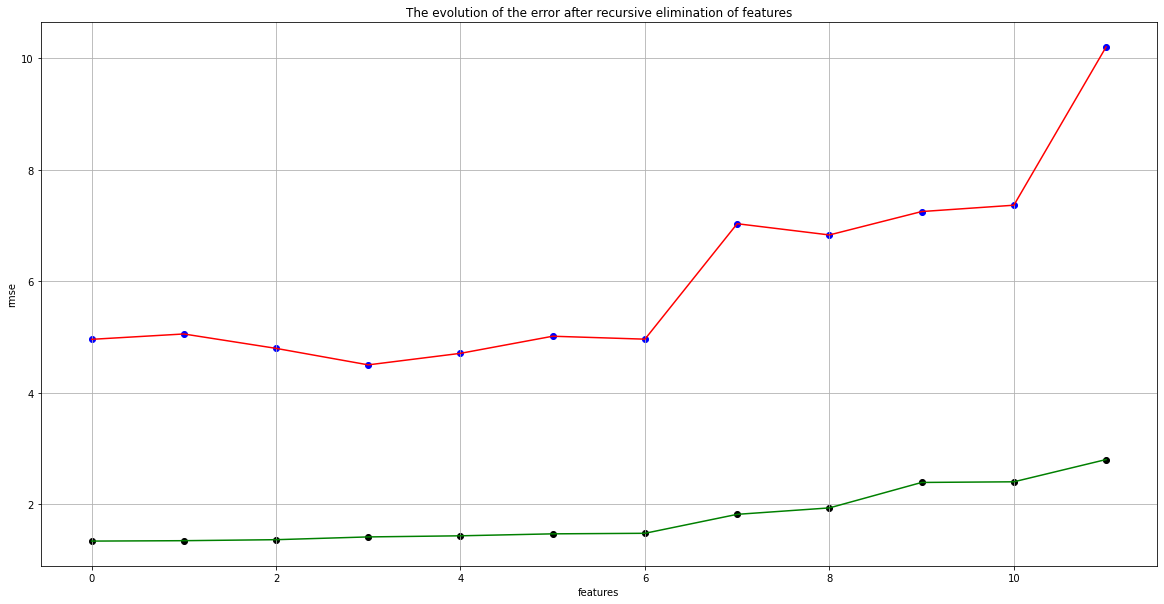

In [122]:
plt.figure(figsize=(20, 10))
plt.plot(rmse_test, color= "red")
plt.plot(rmse_train, color = "green")
plt.scatter(np.arange(12), rmse_train, color = "black")
plt.scatter(np.arange(12), rmse_test, color= "blue")
plt.xlabel("features")
plt.ylabel("rmse")
plt.title("The evolution of the error after recursive elimination of features")
plt.grid(True)


In [112]:
droped_features

['year',
 'hijri_month',
 'hijri_year',
 'subsolar_latitude',
 'libration_lat',
 'sun_moon_distance',
 'earth_sun_distance',
 'libration_long',
 'hour',
 'hijri_day',
 'elongation',
 'earth_moon_distance']

In [133]:
df_train.loc[].head()

,dateTime,moon_phase,earth_moon_distance,sun_moon_distance,libration_lat,libration_long,subsolar_latitude,elongation,earth_sun_distance,hijri_day,hijri_month,hijri_year,hour,year
0,2000-01-01 12:21:00,0.272007,0.002680,0.982105,-0.118238,0.096808,0.011175,-1.094243,0.983332,24,9,1420,12,2000
1,2000-01-02 00:53:00,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325,25,9,1420,0,2000
2,2000-01-02 13:19:00,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325,25,9,1420,13,2000
3,2000-01-03 01:45:00,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322,26,9,1420,1,2000
4,2000-01-03 14:08:00,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322,26,9,1420,14,2000


- So the best score is acheived by deleting:
    - year
    - hijri_month
    - hijri_year

# Predicting for each date the two coefficients using all variables:

In [4]:
DL = DataLoader()
DL.createDataFrameSeperateCoef()
DL.addMoonSunFeatures(two_target=True)
DL.addTimRelatedFeatures(two_target=True)

C:\Users\Otmane\anaconda3\envs\prediciton_of_tidal_coefficient\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


data successfully loaded  with two target features
Features added successfully!
Date-Time features added with sucess!


In [5]:
df = DL.data

In [6]:
df.head()

,min_ceof,max_ceof,moon_phase,earth_moon_distance,sun_moon_distance,libration_lat,libration_long,subsolar_latitude,elongation,earth_sun_distance,hijri_day,hijri_month,hijri_year,year
0,48,48,0.272007,0.002680,0.982105,-0.118238,0.096808,0.011175,-1.094243,0.983332,24,9,1420,2000
1,50,53,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325,25,9,1420,2000
3,56,60,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322,26,9,1420,2000
5,63,66,0.067989,0.002716,0.980974,-0.092156,0.032316,0.009897,-0.525580,0.983323,27,9,1420,2000
7,69,72,0.028386,0.002716,0.980765,-0.074910,0.008569,0.009468,-0.337523,0.983328,28,9,1420,2000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7914 entries, 0 to 15290
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   min_ceof             7914 non-null   int64  
 1   max_ceof             7914 non-null   int64  
 2   moon_phase           7914 non-null   float64
 3   earth_moon_distance  7914 non-null   float64
 4   sun_moon_distance    7914 non-null   float64
 5   libration_lat        7914 non-null   float64
 6   libration_long       7914 non-null   float64
 7   subsolar_latitude    7914 non-null   float64
 8   elongation           7914 non-null   float64
 9   earth_sun_distance   7914 non-null   float64
 10  hijri_day            7914 non-null   int64  
 11  hijri_month          7914 non-null   int64  
 12  hijri_year           7914 non-null   int64  
 13  year                 7914 non-null   int64  
dtypes: float64(8), int64(6)
memory usage: 927.4 KB


In [8]:
df.head()

,min_ceof,max_ceof,moon_phase,earth_moon_distance,sun_moon_distance,libration_lat,libration_long,subsolar_latitude,elongation,earth_sun_distance,hijri_day,hijri_month,hijri_year,year
0,48,48,0.272007,0.002680,0.982105,-0.118238,0.096808,0.011175,-1.094243,0.983332,24,9,1420,2000
1,50,53,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325,25,9,1420,2000
3,56,60,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322,26,9,1420,2000
5,63,66,0.067989,0.002716,0.980974,-0.092156,0.032316,0.009897,-0.525580,0.983323,27,9,1420,2000
7,69,72,0.028386,0.002716,0.980765,-0.074910,0.008569,0.009468,-0.337523,0.983328,28,9,1420,2000


In [11]:
df_train, df_test = df[df.year!=2021], df[df.year==2021]
X_train = df_train.iloc[:,2:]
X_test = df_test.iloc[:,2:]
y_train = df_train.iloc[:, 0:2]
y_test = df_test.iloc[:, 0:2]

In [16]:
RF = RFModel(params = {"n_estimators":100})
RF.fit(X_train,y_train)

In [18]:
y_predicted = RF.predict(X_test)

In [26]:
rmse = mean_squared_error(y_test.values[:,1], y_predicted[:,1])

In [27]:
rmse

26.607594238683124

In [29]:
pd.DataFrame(y_predicted, columns=["min_coef", "max_coef"])

,min_coef,max_coef
0,81.40,82.70
1,79.39,81.80
2,76.47,80.40
3,66.33,70.99
4,59.53,63.85
...,...,...
238,64.68,69.56
239,53.08,58.19
240,41.32,45.99
241,34.01,36.03


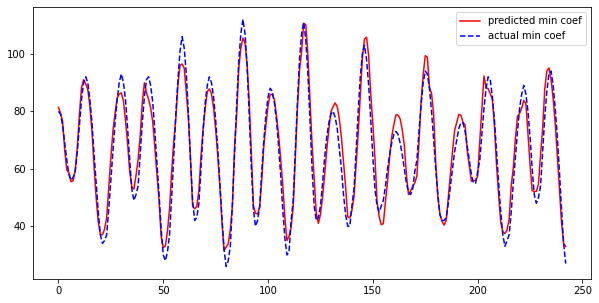

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(y_predicted[:,0].shape[0]), y_predicted[:,0], '-r', label = "predicted min coef")
plt.plot(np.arange(y_test.values[:,0].shape[0]), y_test.values[:,0], '--b', label = 'actual min coef')
plt.legend();

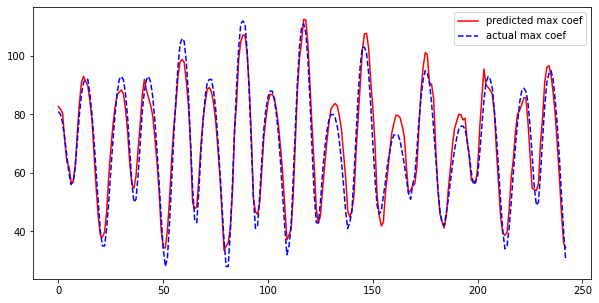

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(y_predicted[:,1].shape[0]), y_predicted[:,1], '-r', label = "predicted max coef")
plt.plot(np.arange(y_test.values[:,1].shape[0]), y_test.values[:,1], '--b', label = 'actual max coef')
plt.legend();

,min_ceof,max_ceof,moon_phase,earth_moon_distance,sun_moon_distance,libration_lat,libration_long,subsolar_latitude,elongation,earth_sun_distance,hijri_day,hijri_month,hijri_year,year
0,48,48,0.272007,0.002680,0.982105,-0.118238,0.096808,0.011175,-1.094243,0.983332,24,9,1420,2000
1,50,53,0.191606,0.002699,0.981656,-0.114317,0.077237,0.010736,-0.903100,0.983325,25,9,1420,2000
3,56,60,0.122970,0.002710,0.981275,-0.105476,0.055455,0.010314,-0.713873,0.983322,26,9,1420,2000
5,63,66,0.067989,0.002716,0.980974,-0.092156,0.032316,0.009897,-0.525580,0.983323,27,9,1420,2000
7,69,72,0.028386,0.002716,0.980765,-0.074910,0.008569,0.009468,-0.337523,0.983328,28,9,1420,2000


In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

LR  = LinearRegression()
SC = StandardScaler()
SC.fit(df.iloc[:,2:])
X_train_scaled = SC.transform(X_train)
X_test_scaled = SC.transform(X_test)
LR.fit(X_train_scaled, y_train)
y_predicted = LR.predict(X_test_scaled)

In [44]:
rmse = mean_squared_error(y_test.values[:,1], y_predicted[:,1])
print(rmse)

294.7078711597422


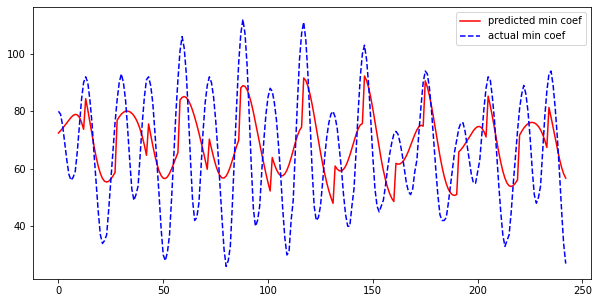

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(y_predicted[:,0].shape[0]), y_predicted[:,0], '-r', label = "predicted min coef")
plt.plot(np.arange(y_test.values[:,0].shape[0]), y_test.values[:,0], '--b', label = 'actual min coef')
plt.legend();